In [1]:
%run setup.py
%config IPython.matplotlib.backend = "retina"

In [3]:
def end(i):
    if i in [0,1]:
        end=','
    if i is 2:
        end=', and'
    if i is 3:
        end='.'
    return end

In [5]:
path=work_path+"sample/rgb/sharpness/mist/"
relations = ["dnu", "numax", "mass", "radius"]
names = ["$\Delta\\nu$", "$\\nu_{\\rm max}$", "$M$", "$R$"]
lnames = ["\Dnu{}", "\\numax{}", "$M$", "$R$"]
llim2_rgb, ellim2_rgb, ulim2_rgb, eulim2_rgb = [np.zeros(4) for i in range(4)]
for i in range(4):
    data = np.load(path+relations[i]+"/llim/data.npy",allow_pickle=True).tolist()
    llim2_rgb[i] = data['para_fit'][1]
    ellim2_rgb[i] =  data['e_para_fit'][1]
    
#     para_fitmax = np.zeros(2)
#     for ipara in range(2):
#         n, bins = np.histogram(data['samples'][:,ipara], 80)
#         idx = np.where(n == n.max())[0][0]
#         para_fitmax[ipara] = bins[idx:idx+1].mean()     
#     llim2[i] = para_fitmax[-1]
#     ellim2[i] =  data['e_para_fit'][1]
    
    
    data = np.load(path+relations[i]+"/ulim/data.npy",allow_pickle=True).tolist()
    ulim2_rgb[i], eulim2_rgb[i] = data['para_fit'][1], data['e_para_fit'][1]

print('The upper limits are')
for i in range(4):
    print("${:0.2f}\%\pm{:0.2f}\%$ ({:s})".format(ulim2_rgb[i]*100, eulim2_rgb[i]*100, lnames[i])+end(i))

print('The lower limits are')
for i in range(4):
    print("${:0.2f}\%$ ({:s})".format(llim2_rgb[i]*100, lnames[i])+end(i))

The upper limits are
$6.41\%\pm0.89\%$ (\Dnu{}),
$9.50\%\pm0.79\%$ (\numax{}),
$4.36\%\pm1.41\%$ ($M$), and
$1.60\%\pm0.60\%$ ($R$).
The lower limits are
$6.68\%$ (\Dnu{}),
$10.46\%$ (\numax{}),
$2.82\%$ ($M$), and
$1.65\%$ ($R$).


# Distributions without perturbations

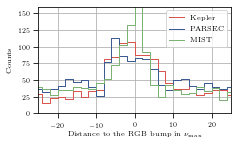

In [26]:
fig = plt.figure(figsize=mnras_size())
axes = fig.subplots(nrows=1, ncols=1, squeeze=False).reshape(-1)
    
def plot_model(distance, variable, xobs, yobs, bump_obs,
            xpdv, ypdv, bump_pdv, label, color):
    
    if variable =='\Delta\\nu':
        bins = np.arange(-3, 3, 0.2)
    elif variable == '\\nu_{\\rm max}':
        bins = np.arange(-33, 33, 2.0)
    elif variable == 'M':
        bins = np.arange(-0.5, 0.5, 0.1)
    elif variable == 'R':
        bins = np.arange(-1., 1., 0.1)
    else:
        pass
    
    # calculate Kepler distance
    hdist_obs, xobs, yobs = distance_to_bump(xobs, yobs, bump_obs, distance=distance)
    obj_obs = distfit(hdist_obs, hist_model, bins=bins)
    obj_obs.fit(ifmcmc=False)

    hdist_pdv, xpdv, ypdv = distance_to_bump(xpdv, ypdv, bump_pdv, distance=distance)
    obj_pdv = distfit(hdist_pdv, hist_model, bins=obj_obs.bins)
    obj_pdv.fit(ifmcmc=False)

    Ndata = xpdv.shape[0]


    weight = np.zeros(obj_obs.histx.shape[0], dtype=bool)
    sigma, x0 = obj_obs.para_fit[0], obj_obs.para_fit[1]
    idx = (obj_obs.histx >= x0-3*sigma) & (obj_obs.histx <= x0+3*sigma)
    weight[idx] = True


    if distance=="vertical":
        fy2_base = np.random.normal(size=Ndata)
        fp = ypdv*fy2_base
    else:
        # fx1 = np.array([random.gauss(0,1) for i in range(Ndata)]) * 10.0**scipy.signal.resample(np.log10(e_xobs), Ndata) * scalar
        # "horizontal"
        fx2_base = np.random.normal(size=Ndata)
        fp = xpdv*fx2_base


    def model(theta):#, obj_obs, xpdv, ypdv):

        # theta[0]: offset in distance
        # theta[1]: perturb

        # disturb with artificial scatter
        # xdata, ydata = (xpdv + xpdv*(fx2_base*theta[1])), (ypdv + ypdv*(fy2_base*theta[1]))

        hdist = hdist_pdv + fp*theta[1]
        hdist = hdist + theta[0]
        obj = distfit(hdist, hist_model, bins=obj_obs.bins)

        # normalize the number of points in the weighted region
        if np.sum(obj.histy[weight])!=0:
            number_reduction_factor = 1. / np.sum(obj.histy[weight])*np.sum(obj_obs.histy[weight])
        else:
            number_reduction_factor = 0.
        histy = obj.histy * number_reduction_factor
        return histy, hdist, number_reduction_factor

    # result plot

    # calculate best fitted results
    para_fit = [0., 0.]
    yfit, hdist, number_reduction_factor = model(para_fit)
    Ndata = hdist.shape[0]
    idx = reduce_samples(Ndata, Ndata*number_reduction_factor)

    if distance=="vertical":
        xdata = xpdv
        ydata = ypdv + fp*para_fit[1]
    else:
        xdata = xpdv + fp*para_fit[1]
        ydata = ypdv

    xfit, yfit = xdata[idx], ydata[idx]
    hdist_fit, xfit, yfit = distance_to_bump(xfit, yfit, bump_pdv, distance=distance)
    hdist_fit = hdist_fit + para_fit[0]

    obj_fit = distfit(hdist_fit, hist_model, bins=obj_obs.bins)
    obj_fit.fit(ifmcmc=False)
    axes[0].step(obj_fit.histx, obj_fit.histy, **{"color":color, "label":label, "linewidth":1})

    return
    



from lib.histdist import distance_to_bump, distfit, model_rgb, reduce_samples

yu = np.load(work_path+'sample/rgb/yu/apk18.npy',allow_pickle=True).tolist()
bump_obs = np.load(work_path+'sample/rgb/yu/numax_bump.npy')

pdv = np.load(work_path+'sample/rgb/padova/padova.npy',allow_pickle=True).tolist()
bump_pdv = np.load(work_path+'sample/rgb/padova/numax_bump.npy')

mist = np.load(work_path+'sample/rgb/mist/mist.npy',allow_pickle=True).tolist()
bump_mist = np.load(work_path+'sample/rgb/mist/numax_bump.npy')

hist_model = model_rgb()


distance = "vertical"
variable = "\\nu_{\\rm max}"
plot_model(distance, variable, yu['teff'], yu['numax'], bump_obs, yu['teff'], yu['numax'], bump_obs,
           'Kepler', red)
plot_model(distance, variable, yu['teff'], yu['numax'], bump_obs, pdv['teff'], pdv['numax'], bump_pdv,
           'PARSEC', blue)
plot_model(distance, variable, yu['teff'], yu['numax'], bump_obs, mist['teff'], mist['numax'], bump_mist,
           'MIST', green)


axes[0].grid(True)
axes[0].set_ylim(0., 160)
axes[0].set_xlim(-25, 25)
axes[0].set_xlabel('Distance to the RGB bump in $'+variable+'$')
axes[0].set_ylabel("Counts")
axes[0].legend(loc='upper right')
# fill weighted region
# xmin_, xmax_ = obj_obs.histx[weight].min(), obj_obs.histx[weight].max()
# lr = xmax_ - xmin_
# axes[0].fill_betweenx(axes[0].get_ylim(), [xmin_, xmin_], [xmax_, xmax_], color="lightgray")
# axes[0].set_xlim(obj_obs.histx.min(), obj_obs.histx.max())

# plt.show()
plt.tight_layout()
plt.savefig(overleaf_path+'rgb_numax.pdf')


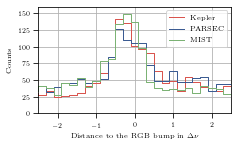

In [28]:
fig = plt.figure(figsize=mnras_size())
axes = fig.subplots(nrows=1, ncols=1, squeeze=False).reshape(-1)
    
def plot_model(distance, variable, xobs, yobs, bump_obs,
            xpdv, ypdv, bump_pdv, label, color):
    
    if variable =='\Delta\\nu':
        bins = np.arange(-3, 3, 0.2)
    elif variable == '\\nu_{\\rm max}':
        bins = np.arange(-33, 33, 2.0)
    elif variable == 'M':
        bins = np.arange(-1., 1., 0.1)
    elif variable == 'R':
        bins = np.arange(-1., 1., 0.1)
    else:
        pass
    
    # calculate Kepler distance
    hdist_obs, xobs, yobs = distance_to_bump(xobs, yobs, bump_obs, distance=distance)
    obj_obs = distfit(hdist_obs, hist_model, bins=bins)
    obj_obs.fit(ifmcmc=False)

    hdist_pdv, xpdv, ypdv = distance_to_bump(xpdv, ypdv, bump_pdv, distance=distance)
    obj_pdv = distfit(hdist_pdv, hist_model, bins=obj_obs.bins)
    obj_pdv.fit(ifmcmc=False)

    Ndata = xpdv.shape[0]


    weight = np.zeros(obj_obs.histx.shape[0], dtype=bool)
    sigma, x0 = obj_obs.para_fit[0], obj_obs.para_fit[1]
    idx = (obj_obs.histx >= x0-3*sigma) & (obj_obs.histx <= x0+3*sigma)
    weight[idx] = True


    if distance=="vertical":
        fy2_base = np.random.normal(size=Ndata)
        fp = ypdv*fy2_base
    else:
        # fx1 = np.array([random.gauss(0,1) for i in range(Ndata)]) * 10.0**scipy.signal.resample(np.log10(e_xobs), Ndata) * scalar
        # "horizontal"
        fx2_base = np.random.normal(size=Ndata)
        fp = xpdv*fx2_base


    def model(theta):#, obj_obs, xpdv, ypdv):

        # theta[0]: offset in distance
        # theta[1]: perturb

        # disturb with artificial scatter
        # xdata, ydata = (xpdv + xpdv*(fx2_base*theta[1])), (ypdv + ypdv*(fy2_base*theta[1]))

        hdist = hdist_pdv + fp*theta[1]
        hdist = hdist + theta[0]
        obj = distfit(hdist, hist_model, bins=obj_obs.bins)

        # normalize the number of points in the weighted region
        if np.sum(obj.histy[weight])!=0:
            number_reduction_factor = 1. / np.sum(obj.histy[weight])*np.sum(obj_obs.histy[weight])
        else:
            number_reduction_factor = 0.
        histy = obj.histy * number_reduction_factor
        return histy, hdist, number_reduction_factor

    # result plot

    # calculate best fitted results
    para_fit = [0., 0.]
    yfit, hdist, number_reduction_factor = model(para_fit)
    Ndata = hdist.shape[0]
    idx = reduce_samples(Ndata, Ndata*number_reduction_factor)

    if distance=="vertical":
        xdata = xpdv
        ydata = ypdv + fp*para_fit[1]
    else:
        xdata = xpdv + fp*para_fit[1]
        ydata = ypdv

    xfit, yfit = xdata[idx], ydata[idx]
    hdist_fit, xfit, yfit = distance_to_bump(xfit, yfit, bump_pdv, distance=distance)
    hdist_fit = hdist_fit + para_fit[0]

    obj_fit = distfit(hdist_fit, hist_model, bins=obj_obs.bins)
    obj_fit.fit(ifmcmc=False)
    axes[0].step(obj_fit.histx, obj_fit.histy, **{"color":color, "label":label, "linewidth":1})

    return
    



from lib.histdist import distance_to_bump, distfit, model_rgb, reduce_samples

yu = np.load(work_path+'sample/rgb/yu/apk18.npy',allow_pickle=True).tolist()
bump_obs = np.load(work_path+'sample/rgb/yu/dnu_bump.npy')

pdv = np.load(work_path+'sample/rgb/padova/padova.npy',allow_pickle=True).tolist()
bump_pdv = np.load(work_path+'sample/rgb/padova/dnu_bump.npy')

mist = np.load(work_path+'sample/rgb/mist/mist.npy',allow_pickle=True).tolist()
bump_mist = np.load(work_path+'sample/rgb/mist/dnu_bump.npy')

hist_model = model_rgb()


distance = "vertical"
variable = "\Delta\\nu"
plot_model(distance, variable, yu['teff'], yu['dnu'], bump_obs, yu['teff'], yu['dnu'], bump_obs,
           'Kepler', red)
plot_model(distance, variable, yu['teff'], yu['dnu'], bump_obs, pdv['teff'], pdv['dnu'], bump_pdv,
           'PARSEC', blue)
plot_model(distance, variable, yu['teff'], yu['dnu'], bump_obs, mist['teff'], mist['dnu'], bump_mist,
           'MIST', green)


axes[0].grid(True)
axes[0].set_ylim(0., 160)
axes[0].set_xlim(-2.5, 2.5)
axes[0].set_xlabel('Distance to the RGB bump in $'+variable+'$')
axes[0].set_ylabel("Counts")
axes[0].legend(loc='upper right')
# fill weighted region
# xmin_, xmax_ = obj_obs.histx[weight].min(), obj_obs.histx[weight].max()
# lr = xmax_ - xmin_
# axes[0].fill_betweenx(axes[0].get_ylim(), [xmin_, xmin_], [xmax_, xmax_], color="lightgray")
# axes[0].set_xlim(obj_obs.histx.min(), obj_obs.histx.max())

# plt.show()
plt.tight_layout()
plt.savefig(overleaf_path+'rgb_dnu.pdf')


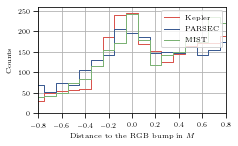

In [37]:
fig = plt.figure(figsize=mnras_size())
axes = fig.subplots(nrows=1, ncols=1, squeeze=False).reshape(-1)
    
def plot_model(distance, variable, xobs, yobs, bump_obs,
            xpdv, ypdv, bump_pdv, label, color):
    
    if variable =='\Delta\\nu':
        bins = np.arange(-3, 3, 0.2)
    elif variable == '\\nu_{\\rm max}':
        bins = np.arange(-33, 33, 2.0)
    elif variable == 'M':
        bins = np.arange(-1., 1., 0.1)
    elif variable == 'R':
        bins = np.arange(-1., 1., 0.1)
    else:
        pass
    
    # calculate Kepler distance
    hdist_obs, xobs, yobs = distance_to_bump(xobs, yobs, bump_obs, distance=distance)
    obj_obs = distfit(hdist_obs, hist_model, bins=bins)
    obj_obs.fit(ifmcmc=False)

    hdist_pdv, xpdv, ypdv = distance_to_bump(xpdv, ypdv, bump_pdv, distance=distance)
    obj_pdv = distfit(hdist_pdv, hist_model, bins=obj_obs.bins)
    obj_pdv.fit(ifmcmc=False)

    Ndata = xpdv.shape[0]


    weight = np.zeros(obj_obs.histx.shape[0], dtype=bool)
    sigma, x0 = obj_obs.para_fit[0], obj_obs.para_fit[1]
    idx = (obj_obs.histx >= x0-3*sigma) & (obj_obs.histx <= x0+3*sigma)
    weight[idx] = True


    if distance=="vertical":
        fy2_base = np.random.normal(size=Ndata)
        fp = ypdv*fy2_base
    else:
        # fx1 = np.array([random.gauss(0,1) for i in range(Ndata)]) * 10.0**scipy.signal.resample(np.log10(e_xobs), Ndata) * scalar
        # "horizontal"
        fx2_base = np.random.normal(size=Ndata)
        fp = xpdv*fx2_base


    def model(theta):#, obj_obs, xpdv, ypdv):

        # theta[0]: offset in distance
        # theta[1]: perturb

        # disturb with artificial scatter
        # xdata, ydata = (xpdv + xpdv*(fx2_base*theta[1])), (ypdv + ypdv*(fy2_base*theta[1]))

        hdist = hdist_pdv + fp*theta[1]
        hdist = hdist + theta[0]
        obj = distfit(hdist, hist_model, bins=obj_obs.bins)

        # normalize the number of points in the weighted region
        if np.sum(obj.histy[weight])!=0:
            number_reduction_factor = 1. / np.sum(obj.histy[weight])*np.sum(obj_obs.histy[weight])
        else:
            number_reduction_factor = 0.
        histy = obj.histy * number_reduction_factor
        return histy, hdist, number_reduction_factor

    # result plot

    # calculate best fitted results
    para_fit = [0., 0.]
    yfit, hdist, number_reduction_factor = model(para_fit)
    Ndata = hdist.shape[0]
    idx = reduce_samples(Ndata, Ndata*number_reduction_factor)

    if distance=="vertical":
        xdata = xpdv
        ydata = ypdv + fp*para_fit[1]
    else:
        xdata = xpdv + fp*para_fit[1]
        ydata = ypdv

    xfit, yfit = xdata[idx], ydata[idx]
    hdist_fit, xfit, yfit = distance_to_bump(xfit, yfit, bump_pdv, distance=distance)
    hdist_fit = hdist_fit + para_fit[0]

    obj_fit = distfit(hdist_fit, hist_model, bins=obj_obs.bins)
    obj_fit.fit(ifmcmc=False)
    axes[0].step(obj_fit.histx, obj_fit.histy, **{"color":color, "label":label, "linewidth":1})

    return
    



from lib.histdist import distance_to_bump, distfit, model_rgb, reduce_samples

yu = np.load(work_path+'sample/rgb/yu/apk18.npy',allow_pickle=True).tolist()
bump_obs = np.load(work_path+'sample/rgb/yu/mr_bump.npy')

pdv = np.load(work_path+'sample/rgb/padova/padova.npy',allow_pickle=True).tolist()
bump_pdv = np.load(work_path+'sample/rgb/padova/mr_bump.npy')

mist = np.load(work_path+'sample/rgb/mist/mist.npy',allow_pickle=True).tolist()
bump_mist = np.load(work_path+'sample/rgb/mist/mr_bump.npy')

hist_model = model_rgb()


distance = "horizontal"
variable = "M"
plot_model(distance, variable, yu['mass'], yu['radius'], bump_obs, yu['mass'], yu['radius'], bump_obs,
           'Kepler', red)
plot_model(distance, variable, yu['mass'], yu['radius'], bump_obs, pdv['mass'], pdv['radius'], bump_pdv,
           'PARSEC', blue)
plot_model(distance, variable, yu['mass'], yu['radius'], bump_obs, mist['mass'], mist['radius'], bump_mist,
           'MIST', green)


axes[0].grid(True)
axes[0].set_ylim(0., 260)
axes[0].set_xlim(-0.8, 0.8)
axes[0].set_xlabel('Distance to the RGB bump in $'+variable+'$')
axes[0].set_ylabel("Counts")
axes[0].legend(loc='upper right')
# fill weighted region
# xmin_, xmax_ = obj_obs.histx[weight].min(), obj_obs.histx[weight].max()
# lr = xmax_ - xmin_
# axes[0].fill_betweenx(axes[0].get_ylim(), [xmin_, xmin_], [xmax_, xmax_], color="lightgray")
# axes[0].set_xlim(obj_obs.histx.min(), obj_obs.histx.max())

# plt.show()
plt.tight_layout()
plt.savefig(overleaf_path+'rgb_mass.pdf')


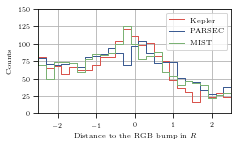

In [36]:
fig = plt.figure(figsize=mnras_size())
axes = fig.subplots(nrows=1, ncols=1, squeeze=False).reshape(-1)
    
def plot_model(distance, variable, xobs, yobs, bump_obs,
            xpdv, ypdv, bump_pdv, label, color):
    
    if variable =='\Delta\\nu':
        bins = np.arange(-3, 3, 0.2)
    elif variable == '\\nu_{\\rm max}':
        bins = np.arange(-33, 33, 2.0)
    elif variable == 'M':
        bins = np.arange(-1., 1., 0.1)
    elif variable == 'R':
        bins = np.arange(-3., 3., 0.2)
    else:
        pass
    
    # calculate Kepler distance
    hdist_obs, xobs, yobs = distance_to_bump(xobs, yobs, bump_obs, distance=distance)
    obj_obs = distfit(hdist_obs, hist_model, bins=bins)
    obj_obs.fit(ifmcmc=False)

    hdist_pdv, xpdv, ypdv = distance_to_bump(xpdv, ypdv, bump_pdv, distance=distance)
    obj_pdv = distfit(hdist_pdv, hist_model, bins=obj_obs.bins)
    obj_pdv.fit(ifmcmc=False)

    Ndata = xpdv.shape[0]


    weight = np.zeros(obj_obs.histx.shape[0], dtype=bool)
    sigma, x0 = obj_obs.para_fit[0], obj_obs.para_fit[1]
    idx = (obj_obs.histx >= x0-3*sigma) & (obj_obs.histx <= x0+3*sigma)
    weight[idx] = True


    if distance=="vertical":
        fy2_base = np.random.normal(size=Ndata)
        fp = ypdv*fy2_base
    else:
        # fx1 = np.array([random.gauss(0,1) for i in range(Ndata)]) * 10.0**scipy.signal.resample(np.log10(e_xobs), Ndata) * scalar
        # "horizontal"
        fx2_base = np.random.normal(size=Ndata)
        fp = xpdv*fx2_base


    def model(theta):#, obj_obs, xpdv, ypdv):

        # theta[0]: offset in distance
        # theta[1]: perturb

        # disturb with artificial scatter
        # xdata, ydata = (xpdv + xpdv*(fx2_base*theta[1])), (ypdv + ypdv*(fy2_base*theta[1]))

        hdist = hdist_pdv + fp*theta[1]
        hdist = hdist + theta[0]
        obj = distfit(hdist, hist_model, bins=obj_obs.bins)

        # normalize the number of points in the weighted region
        if np.sum(obj.histy[weight])!=0:
            number_reduction_factor = 1. / np.sum(obj.histy[weight])*np.sum(obj_obs.histy[weight])
        else:
            number_reduction_factor = 0.
        histy = obj.histy * number_reduction_factor
        return histy, hdist, number_reduction_factor

    # result plot

    # calculate best fitted results
    para_fit = [0., 0.]
    yfit, hdist, number_reduction_factor = model(para_fit)
    Ndata = hdist.shape[0]
    idx = reduce_samples(Ndata, Ndata*number_reduction_factor)

    if distance=="vertical":
        xdata = xpdv
        ydata = ypdv + fp*para_fit[1]
    else:
        xdata = xpdv + fp*para_fit[1]
        ydata = ypdv

    xfit, yfit = xdata[idx], ydata[idx]
    hdist_fit, xfit, yfit = distance_to_bump(xfit, yfit, bump_pdv, distance=distance)
    hdist_fit = hdist_fit + para_fit[0]

    obj_fit = distfit(hdist_fit, hist_model, bins=obj_obs.bins)
    obj_fit.fit(ifmcmc=False)
    axes[0].step(obj_fit.histx, obj_fit.histy, **{"color":color, "label":label, "linewidth":1})

    return
    



from lib.histdist import distance_to_bump, distfit, model_rgb, reduce_samples

yu = np.load(work_path+'sample/rgb/yu/apk18.npy',allow_pickle=True).tolist()
bump_obs = np.load(work_path+'sample/rgb/yu/mr_bump.npy')

pdv = np.load(work_path+'sample/rgb/padova/padova.npy',allow_pickle=True).tolist()
bump_pdv = np.load(work_path+'sample/rgb/padova/mr_bump.npy')

mist = np.load(work_path+'sample/rgb/mist/mist.npy',allow_pickle=True).tolist()
bump_mist = np.load(work_path+'sample/rgb/mist/mr_bump.npy')

hist_model = model_rgb()


distance = "vertical"
variable = "R"
plot_model(distance, variable, yu['mass'], yu['radius'], bump_obs, yu['mass'], yu['radius'], bump_obs,
           'Kepler', red)
plot_model(distance, variable, yu['mass'], yu['radius'], bump_obs, pdv['mass'], pdv['radius'], bump_pdv,
           'PARSEC', blue)
plot_model(distance, variable, yu['mass'], yu['radius'], bump_obs, mist['mass'], mist['radius'], bump_mist,
           'MIST', green)


axes[0].grid(True)
axes[0].set_ylim(0., 150)
axes[0].set_xlim(-2.5, 2.5)
axes[0].set_xlabel('Distance to the RGB bump in $'+variable+'$')
axes[0].set_ylabel("Counts")
axes[0].legend(loc='upper right')
# fill weighted region
# xmin_, xmax_ = obj_obs.histx[weight].min(), obj_obs.histx[weight].max()
# lr = xmax_ - xmin_
# axes[0].fill_betweenx(axes[0].get_ylim(), [xmin_, xmin_], [xmax_, xmax_], color="lightgray")
# axes[0].set_xlim(obj_obs.histx.min(), obj_obs.histx.max())

# plt.show()
plt.tight_layout()
plt.savefig(overleaf_path+'rgb_radius.pdf')


In [ ]:
# fig = plt.figure(figsize=mnras_size())
# axes = fig.subplots(nrows=1, ncols=1, squeeze=False).reshape(-1)
# ind = np.arange(4)
# axes[0].errorbar(ind-0.2, ulim2_rgb*100, yerr=eulim2_rgb*100, color=blue, marker="^",
#                  label="MIST + RGB bump", **errstyle)
# axes[0].errorbar(ind-0.2, llim2_rgb*100, yerr=ellim2_rgb*100, color=blue, marker="v",**errstyle)

# axes[0].errorbar(ind+0.2, ulim2*100, yerr=eulim2*100, color=orange, marker="^", 
#                  label="MIST + zero-age HeB", **errstyle)
# axes[0].errorbar(ind+0.2, llim2*100, yerr=ellim2*100, color=orange, marker="v", **errstyle)

# axes[0].set_xticks(ind)
# axes[0].set_xticklabels(names)
# axes[0].set_ylabel("$\\sigma$ (\%)")
# axes[0].legend()
# plt.tight_layout()
# plt.savefig('/Users/yaguang/Desktop/limits.png')